In [1]:
# Import necessary libraries
import os
from torchvision import datasets

In [2]:
# Load the dataset from the specified directory
dt = datasets.ImageFolder(root=r"C:\Users\vihan\projects\Dataset")

In [3]:
# Print the classes found in the dataset
print(dt.classes)

['beatroot', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'cheesecake', 'chicken curry', 'chicken_wings', 'dhal', 'french_fries', 'fried egg', 'fried_rice', 'ice_cream', 'kottu', 'milk rice', 'omelette', 'red_rice', 'sambol', 'white_rice']


In [4]:
# Print the number of classes in the dataset
print(len(dt.classes))

18


In [5]:
# Print the number of images in the dataset
print(len(dt))

9483


In [6]:
import torch
print(torch.cuda.is_available())

True


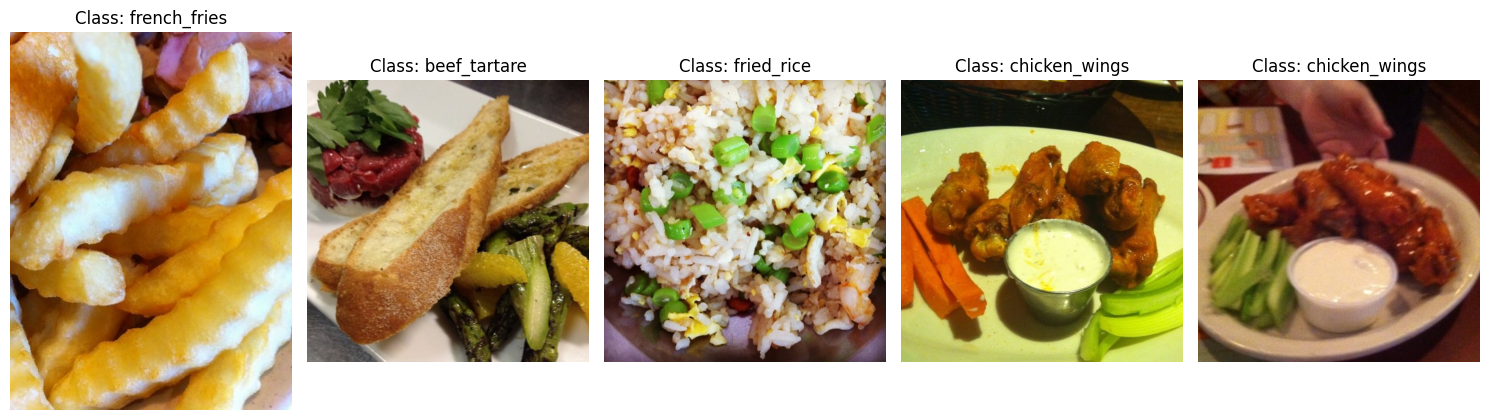

In [7]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Define a transform to convert images to tensors 
transform = transforms.ToTensor()

# Pick some random indices
random_indices = random.sample(range(len(dt)), 5)  # show 5 random images

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image, label = dt[idx]
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {dt.classes[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

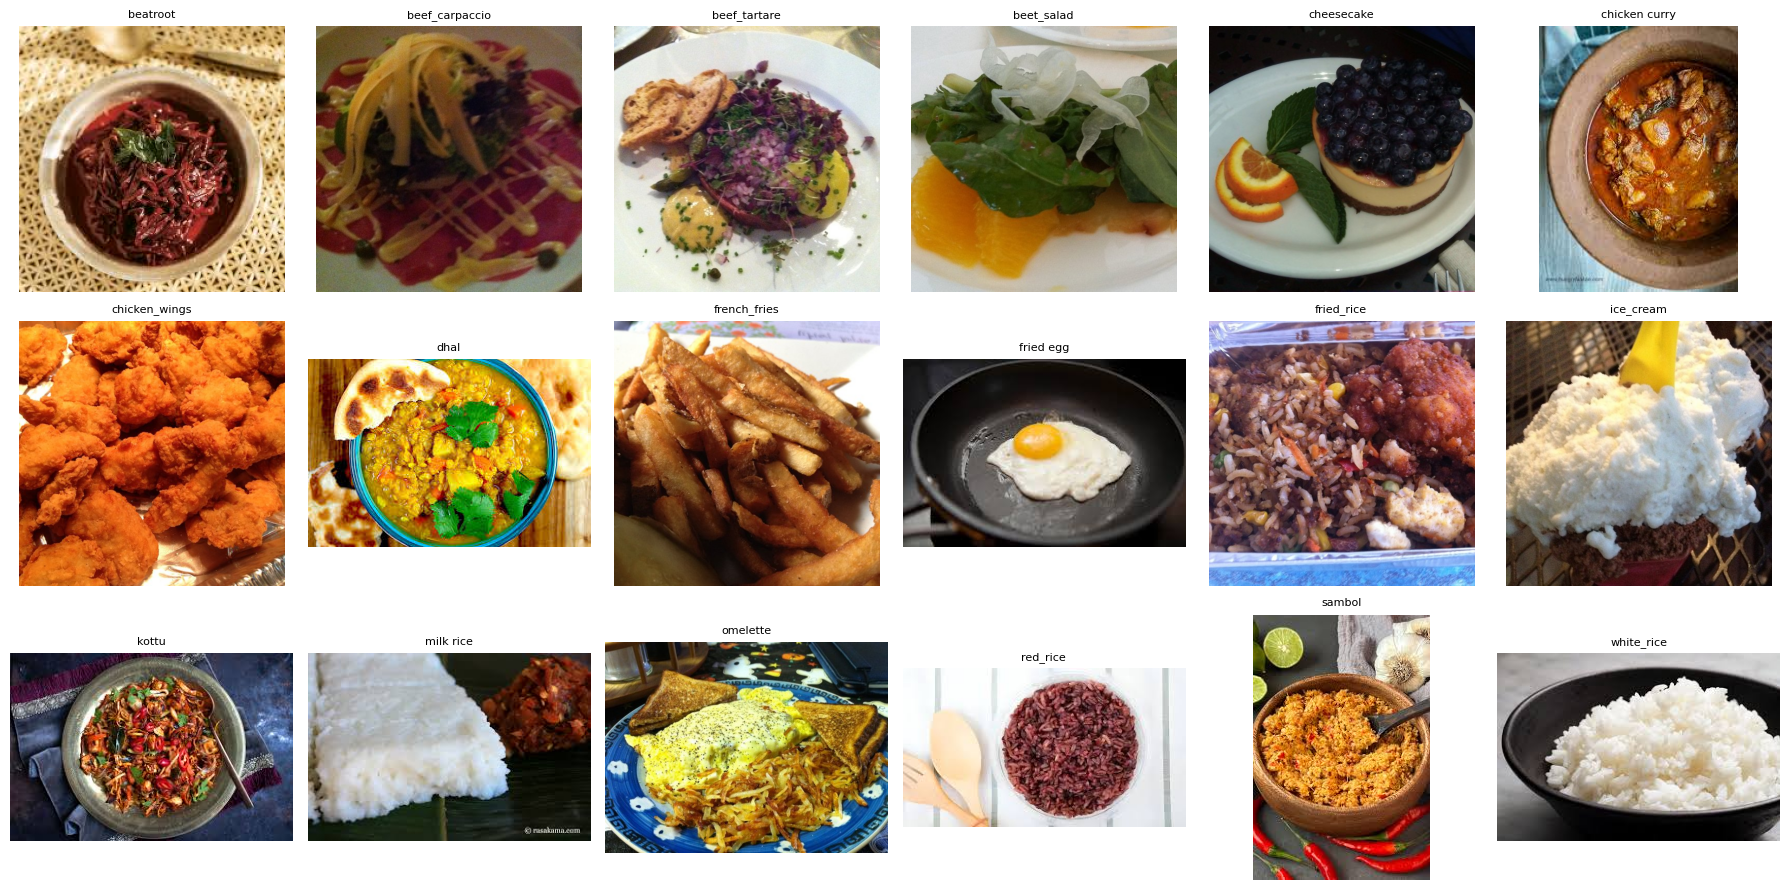

In [8]:
# Show one image per class
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Group indices by class
class_to_indices = {cls_idx: [] for cls_idx in range(len(dt.classes))}

for idx in range(len(dt)):
    _, label = dt[idx]
    class_to_indices[label].append(idx)

# Pick one random index per class
random_indices_per_class = [random.choice(indices) for cls_idx, indices in sorted(class_to_indices.items())]

# Set number of rows and columns 
num_classes = len(dt.classes)
num_cols = 6
num_rows = (num_classes + num_cols - 1) // num_cols  

plt.figure(figsize=(num_cols * 3, num_rows * 3))

for i, idx in enumerate(random_indices_per_class):
    image, label = dt[idx]
    
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image)
    plt.title(f"{dt.classes[label]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


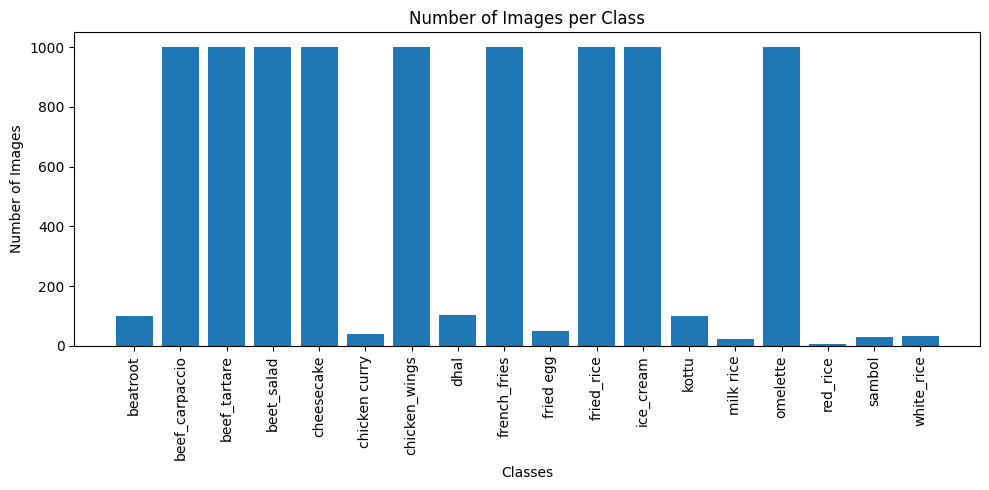

In [9]:
# Distribution of images per class
import matplotlib.pyplot as plt

class_counts = [len(indices) for indices in class_to_indices.values()]

plt.figure(figsize=(10,5))
plt.bar(dt.classes, class_counts)
plt.xticks(rotation=90)
plt.title('Number of Images per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import time

In [11]:
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [12]:
# # transform for training and validation
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
#     transforms.ColorJitter(brightness=0.5, contrast=0.5),
#     transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
#     transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
#     transforms.RandomGrayscale(p=0.2),
#     transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
#     transforms.ToTensor(),
#     transforms.RandomErasing(p=0.5),
#     transforms.Normalize([0.485, 0.456, 0.406], 
#                          [0.229, 0.224, 0.225])
# ])


In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [14]:
# Load dataset and apply transformations
dataset = datasets.ImageFolder(root=r"C:\Users\vihan\projects\Dataset", transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

In [15]:
# Split into train & val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
# DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [17]:
# Pre-trained model
model = models.resnet18(pretrained=True)

C:\Users\vihan\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vihan\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# last layer for 18 classes
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [19]:
# Check if GPU is available and move model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [20]:
# Define the loss function for classification
criterion = nn.CrossEntropyLoss()
# Define the optimizer for model parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# # 8. Training loop with model saving
# def train_model(model, criterion, optimizer, num_epochs=10):
#     best_acc = 0.0  # Variable to track the best accuracy

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()

#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * images.size(0)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         train_loss = running_loss / len(train_loader.dataset)  # Use dataset length instead of train_size
#         train_acc = correct / total

#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

#         # Save the best model
#         if train_acc > best_acc:
#             best_acc = train_acc
#             torch.save(model.state_dict(), 'best_model.pt')  # Save the model state
#             print(f"Best model saved with accuracy: {best_acc:.4f}")

# train_model(model, criterion, optimizer, num_epochs=10)


In [22]:
import torch

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0  # Variable to track the best accuracy

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Save the best model as TorchScript
        if train_acc > best_acc:
            best_acc = train_acc
            model.eval()
            scripted_model = torch.jit.script(model)  # Script the model
            scripted_model.save('saved_model.pt')  # Save the TorchScript model
            print(f"Best model saved with accuracy: {best_acc:.4f}")

train_model(model, criterion, optimizer, num_epochs=10)


Epoch 1/10, Loss: 1.1103, Accuracy: 0.6534
Best model saved with accuracy: 0.6534
Epoch 2/10, Loss: 0.7642, Accuracy: 0.7592
Best model saved with accuracy: 0.7592
Epoch 3/10, Loss: 0.6130, Accuracy: 0.8012
Best model saved with accuracy: 0.8012
Epoch 4/10, Loss: 0.5000, Accuracy: 0.8427
Best model saved with accuracy: 0.8427
Epoch 5/10, Loss: 0.4664, Accuracy: 0.8484
Best model saved with accuracy: 0.8484
Epoch 6/10, Loss: 0.3404, Accuracy: 0.8912
Best model saved with accuracy: 0.8912
Epoch 7/10, Loss: 0.3407, Accuracy: 0.8839
Epoch 8/10, Loss: 0.2784, Accuracy: 0.9102
Best model saved with accuracy: 0.9102
Epoch 9/10, Loss: 0.2620, Accuracy: 0.9131
Best model saved with accuracy: 0.9131
Epoch 10/10, Loss: 0.1811, Accuracy: 0.9412
Best model saved with accuracy: 0.9412


In [23]:
from PIL import Image

def predict_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
        print(f"Predicted Class: {class_names[pred.item()]}")

predict_image(r"C:\Users\vihan\Downloads\fried rice.jpg")

Predicted Class: fried_rice


In [24]:
import torch
from torchvision import datasets, transforms
from PIL import Image

# Define your transformation (adjust as necessary for your model)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to the model's expected input size
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats (if using a model trained on ImageNet)
])

# Load dataset and apply transformations
dataset = datasets.ImageFolder(root=r"C:\Users\vihan\projects\Dataset", transform=transform)
class_names = dataset.classes  # Automatically get class names from folder structure
num_classes = len(class_names)  # Get number of classes

# Define the model architecture (ensure it matches the saved model)
model = models.resnet18(pretrained=False)  # Use the same architecture as the saved model
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the final layer for the number of classes

# Load the saved state dictionary
model.load_state_dict(torch.load(r'C:\Users\vihan\projects\final-one\models\best_model.pt'))
model.eval()  # Set the model to evaluation mode

# Define device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_image(img_path):
    # Open image and apply transformations
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send image to the device
    
    # Predict using the model
    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(image)  # Forward pass
        _, pred = torch.max(output, 1)  # Get predicted class index
        print(f"Predicted Class: {class_names[pred.item()]}")

# Provide the correct path to your image
predict_image(r"C:\Users\vihan\Downloads\dha.jpg")


C:\Users\vihan\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted Class: dhal
